# Bitcoin Project

In [69]:
#import all dependencies
from coinapi_rest_v1 import CoinAPIv1
import datetime, sys
import psycopg2
import sqlalchemy
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt 
import seaborn as sns
from sklearn import preprocessing
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [23]:
#connect to coinapi
test_key = ' 82AC4DC1-5DAA-4F7A-AEE1-9E05B56E576F' #can only make 100 calls per day on this key
api = CoinAPIv1(test_key)

## Working with Postgres

In [26]:
#load data to postgres via psycopg2
#please make your own postgres database and update your fields

connection = psycopg2.connect(user = "jenna",
                                  password = "pwd",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "coinapi")
cursor = connection.cursor()
bitcoin_types = {'dog':'YOBIT_SPOT_DOGE_USD','btc':'CRYPTOPIA_SPOT_BTC_USDT','eth':'BINANCE_SPOT_ETH_USDT','xrp':'BITTREX_SPOT_XRP_USDT'}

for table_name, symbol_id in bitcoin_types.items():
    #create the table
    
    create_table_query = '''CREATE TABLE %s
              (time_open date PRIMARY KEY     NOT NULL,
              stamp             TEXT    NOT NULL,
              price_low         REAL,
              price_high        REAL,
              volume_traded     REAL,
              trades_count      INT); '''
    cursor.execute(create_table_query % table_name)

    # insert the bitcoin data. Each api call can only take 100 rows, 
    # so we have to make several api calls to fetch a full year of data
    start_of_2018 = datetime.date(2018, 1, 1).isoformat()
    historical_trades = api.ohlcv_historical_data(symbol_id, {'period_id': '1DAY', 'time_start': start_of_2018})
    for period in historical_trades:
        query = "INSERT INTO {0} VALUES (DATE_TRUNC('sec', '{1}'::timestamp),'{2}',{3},{4},{5},{6})".format(table_name,period['time_open'],symbol_id,period['price_low'],period['price_high'],period['volume_traded'],period['trades_count'])
        try:
            cursor.execute(query)
        except:
            pass
    start_of_2018 = datetime.date(2018, 4, 14).isoformat()
    historical_trades = api.ohlcv_historical_data(symbol_id, {'period_id': '1DAY', 'time_start': start_of_2018})
    for period in historical_trades:
        query = "INSERT INTO {0} VALUES (DATE_TRUNC('sec', '{1}'::timestamp),'{2}',{3},{4},{5})".format(table_name,period['time_open'],symbol_id,period['price_low'],period['price_high'],period['volume_traded'],period['trades_count'])
        try:
            cursor.execute(query)
        except: 
            connection = psycopg2.connect(user = "jenna",
                                  password = "pwd",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "coinapi")
            cursor = connection.cursor()
    start_of_2018 = datetime.date(2018, 8, 16).isoformat()
    historical_trades = api.ohlcv_historical_data(symbol_id, {'period_id': '1DAY', 'time_start': start_of_2018})
    for period in historical_trades:
        query = "INSERT INTO {0} VALUES (DATE_TRUNC('sec', '{1}'::timestamp),'{2}',{3},{4},{5})".format(table_name,period['time_open'],symbol_id,period['price_low'],period['price_high'],period['volume_traded'],period['trades_count'])
        try:
            cursor.execute(query)
        except UniqueViolation:
            connection = psycopg2.connect(user = "jenna",
                                  password = "pwd",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "coinapi")
            cursor = connection.cursor()
    start_of_2018 = datetime.date(2018, 11, 24).isoformat()
    end_of_2018 = datetime.date(2019, 1, 1).isoformat()
    historical_trades = api.ohlcv_historical_data(symbol_id, {'period_id': '1DAY', 'time_start': start_of_2018,'time_end': end_of_2018})
    for period in historical_trades:
        query = "INSERT INTO {0} VALUES (DATE_TRUNC('sec', '{1}'::timestamp),'{2}',{3},{4},{5})".format(table_name,period['time_open'],symbol_id, period['price_low'],period['price_high'],period['volume_traded'],period['trades_count'])
        try:
            cursor.execute(query)
        except UniqueViolation:
            connection = psycopg2.connect(user = "jenna",
                                  password = "pwd",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "coinapi")
            cursor = connection.cursor()
connection.commit()
connection.close()
cursor.close()


In [127]:

#read data into a python DataFrame
connection = psycopg2.connect(user = "jenna",
                                  password = "pwd",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "coinapi")
#only read in numerical data which can be used to train our LSTM network
dog = pd.read_sql('select price_low, price_high, volume_traded from dog;', connection)
btc = pd.read_sql('select price_low, price_high, volume_traded from btc;', connection)
eth = pd.read_sql('select price_low, price_high, volume_traded from eth;', connection)
xrp = pd.read_sql('select price_low, price_high, volume_traded from xrp;', connection)
dates = pd.read_sql('select time_open from dog;', connection)
#here's what a table looks like:
dog.head()

,price_low,price_high,volume_traded
0,0.009405,0.009580,411106.0
1,0.009302,0.010035,519354.0
2,0.009510,0.009800,384527.0
3,0.009649,0.009890,609096.0
4,0.011350,0.011893,534077.0


# LSTM Model

In [28]:

#Create functions for LSTM model

# convert series to supervised learning to use as input for our network
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#our neural network
def network(dataset, n_train_days, lookback = 1, n_features=3, epoch=30, batch_sz=30):
    '''
    Parameters:
    -n_train_days specifies amount of data to set for training 
    -lookback specify the number of lag samples
    -n_features specifies the number of features in dataset
    -epoch specifies how many epochs to run the LSTM on
    -batch_sz limits the number of samples to be shown to the network before a weight update can be performed in our LSTM.
    
    '''
    
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    
    # Normalizing the input data using MinMaxScaler so all input features are on a scale from 0 to 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

     

    # frame as supervised learning
    reframed = series_to_supervised(scaled, lookback, 1)
    #only want to predict one feature, price_high
    reframed.drop(reframed.columns[[i for i in range(n_features,n_features*2)]], axis=1, inplace=True)

    #make sure we have the correct number of columns accounted for
    print(reframed.shape)

    # split into train and test sets
    values = reframed.values
    #hold out appox 30% for testing
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    n_obs = lookback * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)

    # LSTM expects the input data in a specific 3D format of [test sample size, time steps, no. of input features].
    train_X = train_X.reshape((train_X.shape[0], lookback, n_features))
    test_X = test_X.reshape((test_X.shape[0], lookback, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


    # Setup our neural network with loss and optimization models
    model = Sequential()
    model.add(LSTM(epoch, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch_sz, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()


    # make a prediction for test data
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], lookback*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # make a prediction for training data
    tr_yhat = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], lookback*n_features))

    tr_inv_yhat = concatenate((tr_yhat, train_X[:, 1:]), axis=1)
    tr_inv_yhat = scaler.inverse_transform(tr_inv_yhat)
    tr_inv_yhat = tr_inv_yhat[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    tr_inv_y = concatenate((train_y, train_X[:, 1:]), axis=1)
    tr_inv_y = scaler.inverse_transform(tr_inv_y)
    tr_inv_y = tr_inv_y[:,0]
    # calculate RMSE
    test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    train_rmse = sqrt(mean_squared_error(tr_inv_y, tr_inv_yhat))
    print('Test RMSE: %.3f' % test_rmse)
    print('Train RMSE: %.3f' %train_rmse)
    #return error, actual test values, predicted test values
    return test_rmse, train_rmse, inv_y, inv_yhat

#plot our forcast data vs actual data
def plot_forecast(forecast):
    pyplot.figure(figsize=(20,10))
    pyplot.plot(forecast[2],color='blue',label='actual')
    pyplot.plot(forecast[3],color='red', label ='predicted')
    pyplot.legend()
    pyplot.title("Low Price- Actual vs Predicted")
    pyplot.show()
    pass

(337, 3)
(250, 3) 250 (250,)
(250, 1, 3) (250,) (87, 1, 3) (87,)
Train on 250 samples, validate on 87 samples
Epoch 1/100
 - 0s - loss: 0.3656 - val_loss: 0.1118
Epoch 2/100
 - 0s - loss: 0.2890 - val_loss: 0.0921
Epoch 3/100
 - 0s - loss: 0.2087 - val_loss: 0.0807
Epoch 4/100
 - 0s - loss: 0.1236 - val_loss: 0.0809
Epoch 5/100
 - 0s - loss: 0.0824 - val_loss: 0.1275
Epoch 6/100
 - 0s - loss: 0.0724 - val_loss: 0.1334
Epoch 7/100
 - 0s - loss: 0.0642 - val_loss: 0.1167
Epoch 8/100
 - 0s - loss: 0.0578 - val_loss: 0.0980
Epoch 9/100
 - 0s - loss: 0.0577 - val_loss: 0.0884
Epoch 10/100
 - 0s - loss: 0.0576 - val_loss: 0.0877
Epoch 11/100
 - 0s - loss: 0.0544 - val_loss: 0.0876
Epoch 12/100
 - 0s - loss: 0.0507 - val_loss: 0.0840
Epoch 13/100
 - 0s - loss: 0.0472 - val_loss: 0.0781
Epoch 14/100
 - 0s - loss: 0.0446 - val_loss: 0.0734
Epoch 15/100
 - 0s - loss: 0.0420 - val_loss: 0.0699
Epoch 16/100
 - 0s - loss: 0.0385 - val_loss: 0.0649
Epoch 17/100
 - 0s - loss: 0.0355 - val_loss: 0.060

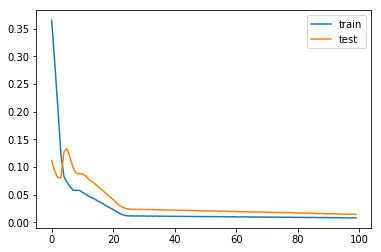

Test RMSE: 232.412
Train RMSE: 145.633


In [118]:
#run lstm model for predictive modeling
btc_network = network(btc, 250, n_features= 3 , lookback=1, epoch=100)

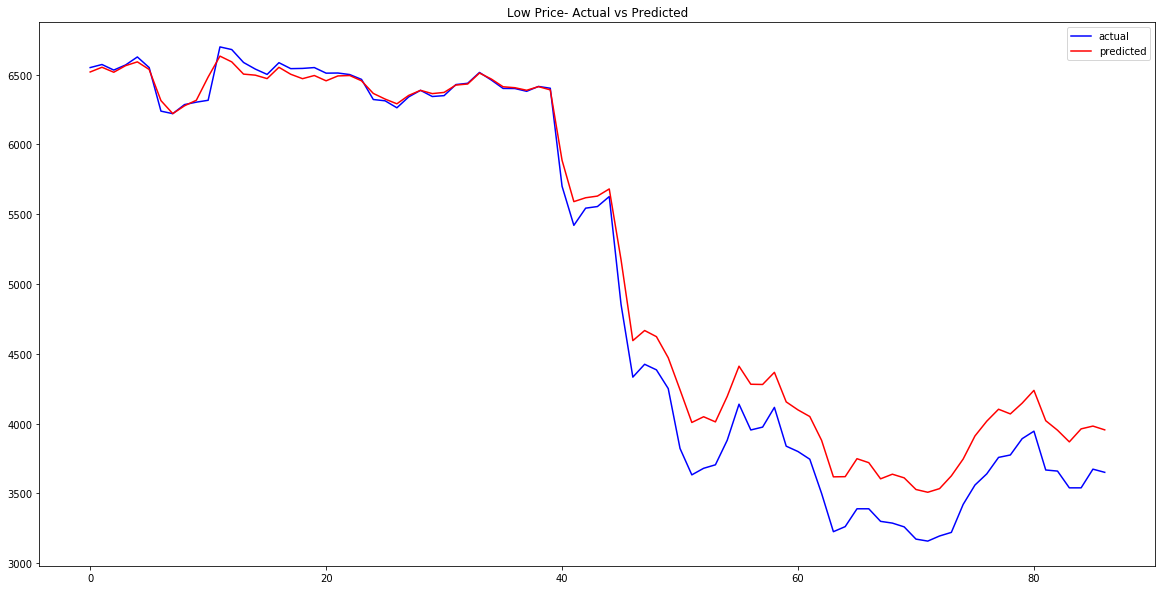

In [121]:
plot_forecast(btc_network)

(337, 3)
(250, 3) 250 (250,)
(250, 1, 3) (250,) (87, 1, 3) (87,)
Train on 250 samples, validate on 87 samples
Epoch 1/100
 - 0s - loss: 0.1688 - val_loss: 0.0642
Epoch 2/100
 - 0s - loss: 0.1364 - val_loss: 0.0642
Epoch 3/100
 - 0s - loss: 0.1206 - val_loss: 0.0660
Epoch 4/100
 - 0s - loss: 0.1114 - val_loss: 0.0663
Epoch 5/100
 - 0s - loss: 0.1040 - val_loss: 0.0668
Epoch 6/100
 - 0s - loss: 0.0973 - val_loss: 0.0666
Epoch 7/100
 - 0s - loss: 0.0904 - val_loss: 0.0656
Epoch 8/100
 - 0s - loss: 0.0836 - val_loss: 0.0638
Epoch 9/100
 - 0s - loss: 0.0766 - val_loss: 0.0610
Epoch 10/100
 - 0s - loss: 0.0693 - val_loss: 0.0573
Epoch 11/100
 - 0s - loss: 0.0617 - val_loss: 0.0531
Epoch 12/100
 - 0s - loss: 0.0539 - val_loss: 0.0485
Epoch 13/100
 - 0s - loss: 0.0462 - val_loss: 0.0429
Epoch 14/100
 - 0s - loss: 0.0384 - val_loss: 0.0371
Epoch 15/100
 - 0s - loss: 0.0308 - val_loss: 0.0310
Epoch 16/100
 - 0s - loss: 0.0231 - val_loss: 0.0226
Epoch 17/100
 - 0s - loss: 0.0176 - val_loss: 0.017

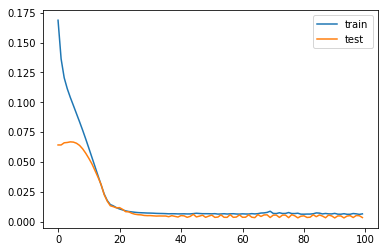

Test RMSE: 0.000
Train RMSE: 0.000


In [119]:
dog_network = network(dog, 250, n_features= 3 , lookback=1, epoch=100)

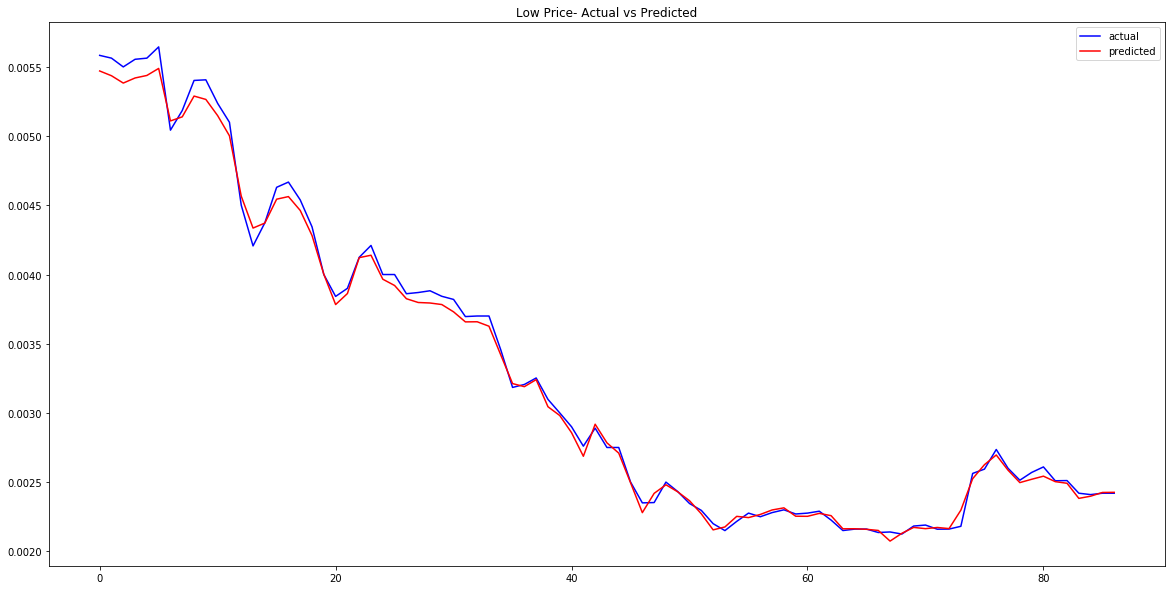

In [120]:
plot_forecast(dog_network)

(337, 3)
(250, 3) 250 (250,)
(250, 1, 3) (250,) (87, 1, 3) (87,)
Train on 250 samples, validate on 87 samples
Epoch 1/100
 - 0s - loss: 0.4076 - val_loss: 0.0493
Epoch 2/100
 - 0s - loss: 0.3389 - val_loss: 0.0538
Epoch 3/100
 - 0s - loss: 0.2819 - val_loss: 0.0863
Epoch 4/100
 - 0s - loss: 0.2326 - val_loss: 0.1246
Epoch 5/100
 - 0s - loss: 0.1892 - val_loss: 0.1585
Epoch 6/100
 - 0s - loss: 0.1480 - val_loss: 0.1883
Epoch 7/100
 - 0s - loss: 0.1210 - val_loss: 0.2079
Epoch 8/100
 - 0s - loss: 0.1042 - val_loss: 0.2106
Epoch 9/100
 - 0s - loss: 0.0942 - val_loss: 0.2007
Epoch 10/100
 - 0s - loss: 0.0859 - val_loss: 0.1838
Epoch 11/100
 - 0s - loss: 0.0789 - val_loss: 0.1654
Epoch 12/100
 - 0s - loss: 0.0730 - val_loss: 0.1489
Epoch 13/100
 - 0s - loss: 0.0671 - val_loss: 0.1340
Epoch 14/100
 - 0s - loss: 0.0607 - val_loss: 0.1202
Epoch 15/100
 - 0s - loss: 0.0535 - val_loss: 0.1054
Epoch 16/100
 - 0s - loss: 0.0462 - val_loss: 0.0901
Epoch 17/100
 - 0s - loss: 0.0388 - val_loss: 0.074

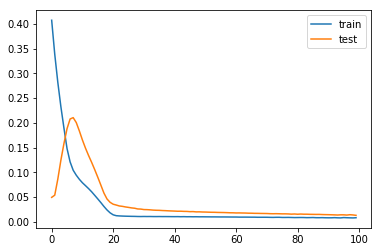

Test RMSE: 16.678
Train RMSE: 14.628


In [123]:
eth_network = network(eth, 250, n_features= 3 , lookback=1, epoch=100)

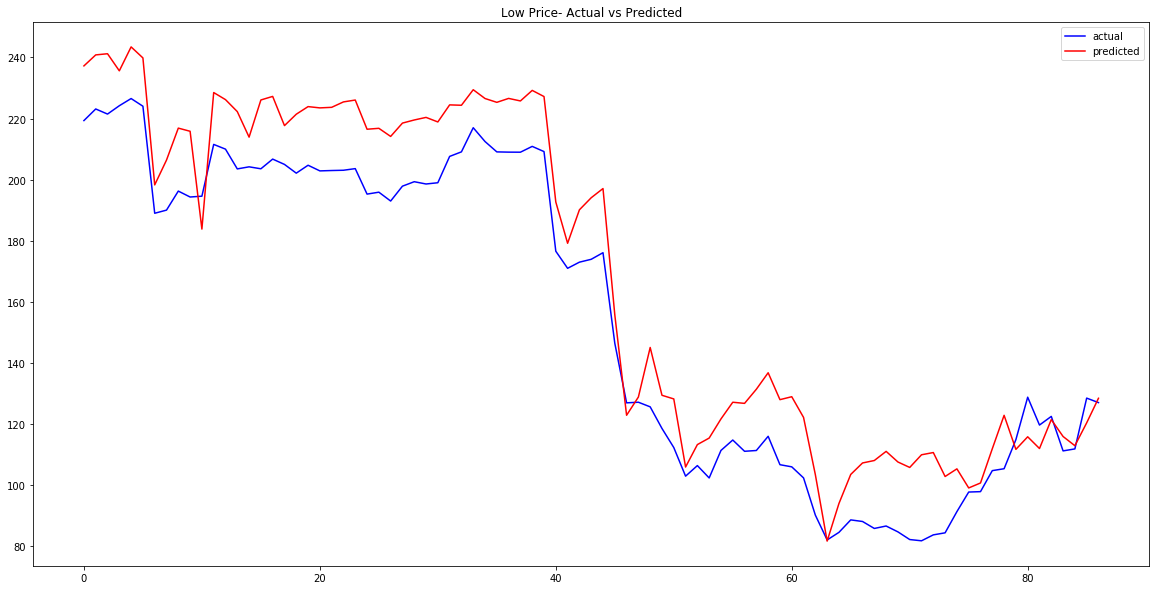

In [124]:
plot_forecast(eth_network)

(337, 3)
(250, 3) 250 (250,)
(250, 1, 3) (250,) (87, 1, 3) (87,)
Train on 250 samples, validate on 87 samples
Epoch 1/100
 - 0s - loss: 0.1831 - val_loss: 0.0327
Epoch 2/100
 - 0s - loss: 0.1465 - val_loss: 0.0248
Epoch 3/100
 - 0s - loss: 0.1160 - val_loss: 0.0410
Epoch 4/100
 - 0s - loss: 0.0994 - val_loss: 0.0614
Epoch 5/100
 - 0s - loss: 0.0892 - val_loss: 0.0708
Epoch 6/100
 - 0s - loss: 0.0829 - val_loss: 0.0714
Epoch 7/100
 - 0s - loss: 0.0783 - val_loss: 0.0669
Epoch 8/100
 - 0s - loss: 0.0743 - val_loss: 0.0610
Epoch 9/100
 - 0s - loss: 0.0710 - val_loss: 0.0560
Epoch 10/100
 - 0s - loss: 0.0677 - val_loss: 0.0524
Epoch 11/100
 - 0s - loss: 0.0639 - val_loss: 0.0489
Epoch 12/100
 - 0s - loss: 0.0600 - val_loss: 0.0456
Epoch 13/100
 - 0s - loss: 0.0558 - val_loss: 0.0416
Epoch 14/100
 - 0s - loss: 0.0515 - val_loss: 0.0365
Epoch 15/100
 - 0s - loss: 0.0477 - val_loss: 0.0326
Epoch 16/100
 - 0s - loss: 0.0434 - val_loss: 0.0292
Epoch 17/100
 - 0s - loss: 0.0390 - val_loss: 0.025

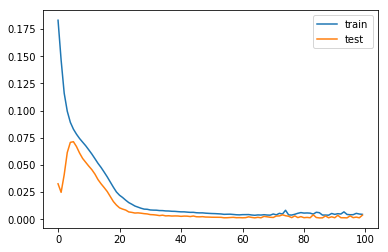

Test RMSE: 0.010
Train RMSE: 0.025


In [125]:
xrp_network = network(xrp, 250, n_features= 3 , lookback=1, epoch=100)

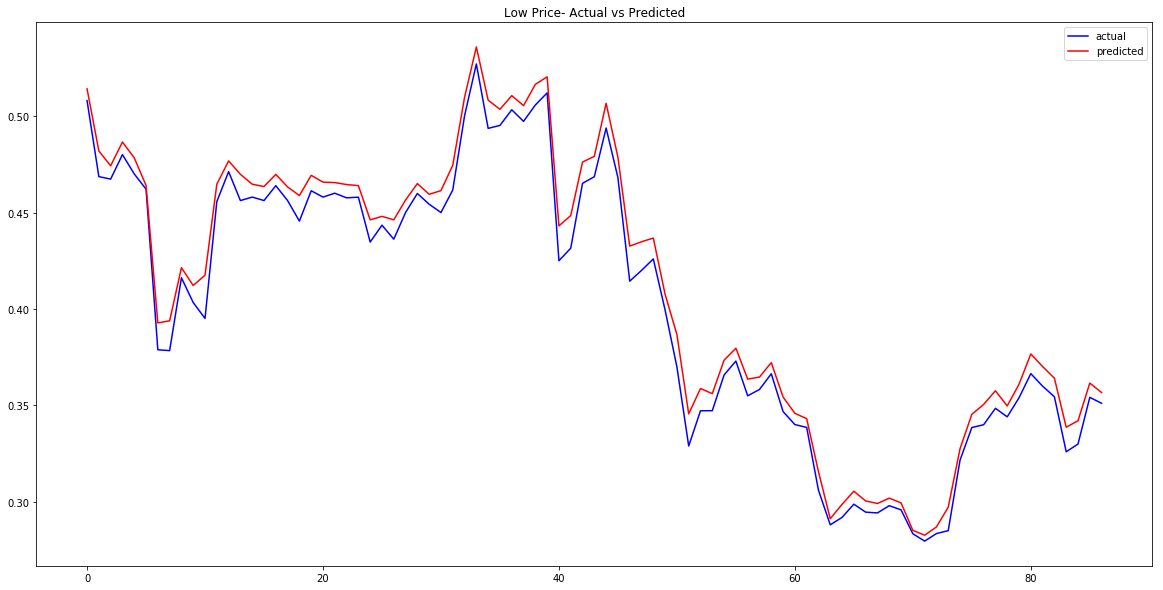

In [126]:
plot_forecast(xrp_network)

Text(0.5, 1.0, 'Low Price of Bitcoins in 2018')

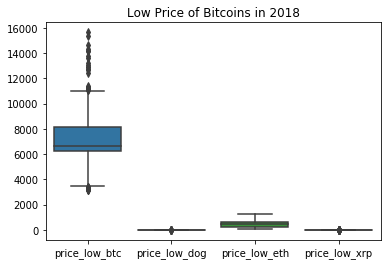

In [72]:
#visualize data and results to find patterns 
bitcoin_datasets = pd.merge(btc['price_low'],dog['price_low'],left_index=True, right_index=True, suffixes =('_btc','_dog'))
bitcoin_datasets = pd.merge(bitcoin_datasets ,eth['price_low'],left_index=True, right_index=True)
bitcoin_datasets = pd.merge(bitcoin_datasets ,xrp['price_low'],left_index=True, right_index=True, suffixes =('_eth','_xrp'))
bitcoin_datasets
sns.boxplot(data=bitcoin_datasets).set_title('Low Price of Bitcoins in 2018')


### Normalize Data

As you can see from the above box plot, the data are on very different scales, so we should normalize the data so that we can compare them.

In [97]:
def normalize(series):
    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    scaled = min_max_scaler.fit_transform(series)

    # Run the normalizer on the dataframe
    normalized = pd.DataFrame(scaled)
    # View the dataframe
    return normalized


normalized_df = pd.DataFrame()
cols = ['price_low','price_high']
for col in cols:
    dog_shaped = dog[col].values.astype(float).reshape(-1, 1)
    btc_shaped = btc[col].values.astype(float).reshape(-1, 1)
    eth_shaped = eth[col].values.astype(float).reshape(-1, 1)
    xrp_shaped = xrp[col].values.astype(float).reshape(-1, 1)
    normalized_df = pd.concat((normalized_df, normalize(dog_shaped)), axis=1 ) 
    normalized_df = pd.concat((normalized_df, normalize(btc_shaped)), axis=1 ) 
    normalized_df = pd.concat((normalized_df, normalize(eth_shaped)), axis=1 )
    normalized_df = pd.concat((normalized_df, normalize(xrp_shaped)), axis=1) 
normalized_df.columns = ['dog_low','btc_low','eth_low','xrp_low','dog_high','btc_high','eth_high','xrp_high']    

Text(0.5, 1.0, 'Low Price of Bitcoins in 2018')

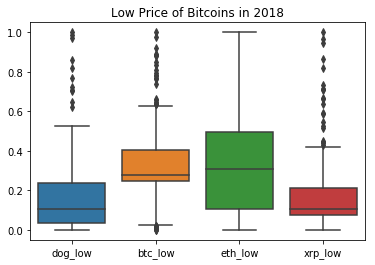

In [112]:
sns.boxplot(data=normalized_df[['dog_low','btc_low','eth_low','xrp_low']]).set_title('Low Price of Bitcoins in 2018')

Text(0.5, 1.0, 'High Price of Bitcoins in 2018')

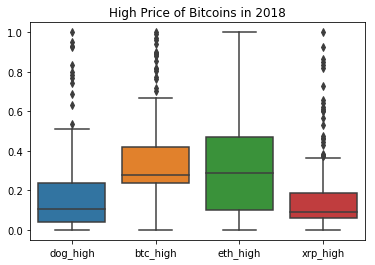

In [113]:
sns.boxplot(data=normalized_df[['dog_high','btc_high','eth_high','xrp_high']]).set_title('High Price of Bitcoins in 2018')


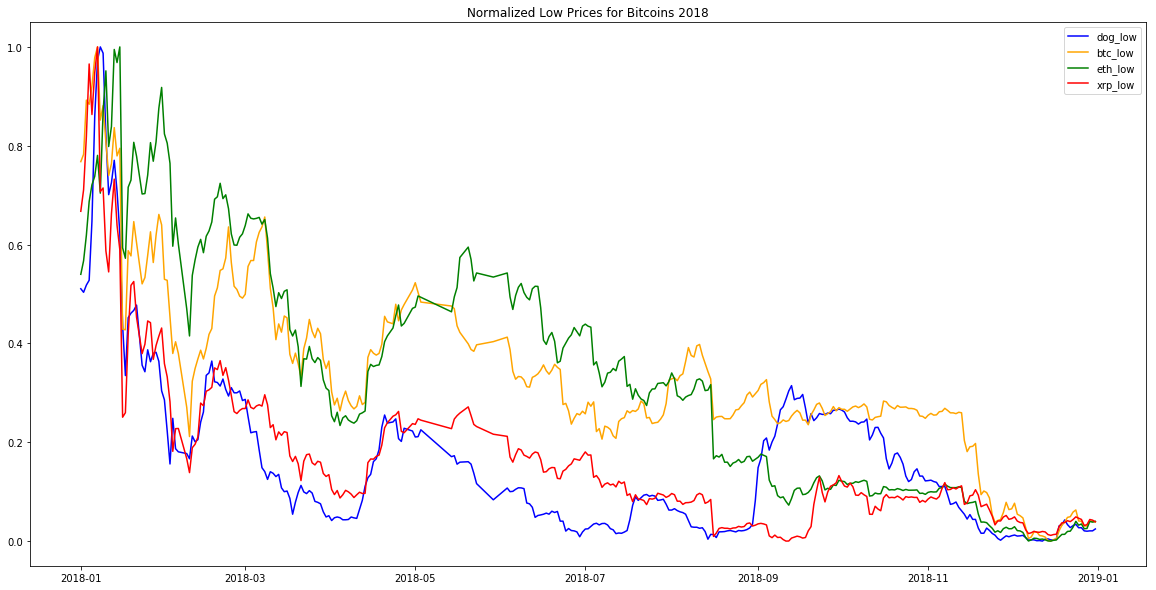

In [139]:

pyplot.figure(figsize=(20,10))
pyplot.plot(dates, normalized_df.dog_low,color='blue',label='dog_low')
pyplot.plot(dates, normalized_df.btc_low,color='orange',label='btc_low')
pyplot.plot(dates, normalized_df.eth_low,color='green',label='eth_low')
pyplot.plot(dates, normalized_df.xrp_low,color='red',label='xrp_low')
pyplot.legend()
pyplot.title("Normalized Low Prices for Bitcoins 2018")
pyplot.show()
